Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /aiffel/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
94781440/94765736 [==============================] - 0s 0us/step

Training Conv2D Model:
Epoch 1/5
92/92 [==============================] - 55s 45ms/step - loss: 1.3408 - accuracy: 0.4339 - val_loss: 1.0617 - val_accuracy: 0.5749
Epoch 2/5
92/92 [==============================] - 3s 26ms/step - loss: 0.9877 - accuracy: 0.6042 - val_loss: 0.9740 - val_accuracy: 0.6213
Epoch 3/5
92/92 [==============================] - 3s 23ms/step - loss: 0.7458 - accuracy: 0.7258 - val_loss: 0.8073 - val_accuracy: 0.6730
Epoch 4/5
92/92 [==============================] - 3s 24ms/step - loss: 0.5152 - accuracy: 0.8140 - val_loss: 0.8793 - val_accuracy: 0.6594
Epoch 5/5
92/92 [==============================] - 3s 24ms/step - loss: 0.2854 - accuracy: 0.9019 - val_loss: 1.0151 - val_accuracy: 0.6676

Training VGG19 Model:
Epoch 1/5
92/92 [==============================] - 19s 1

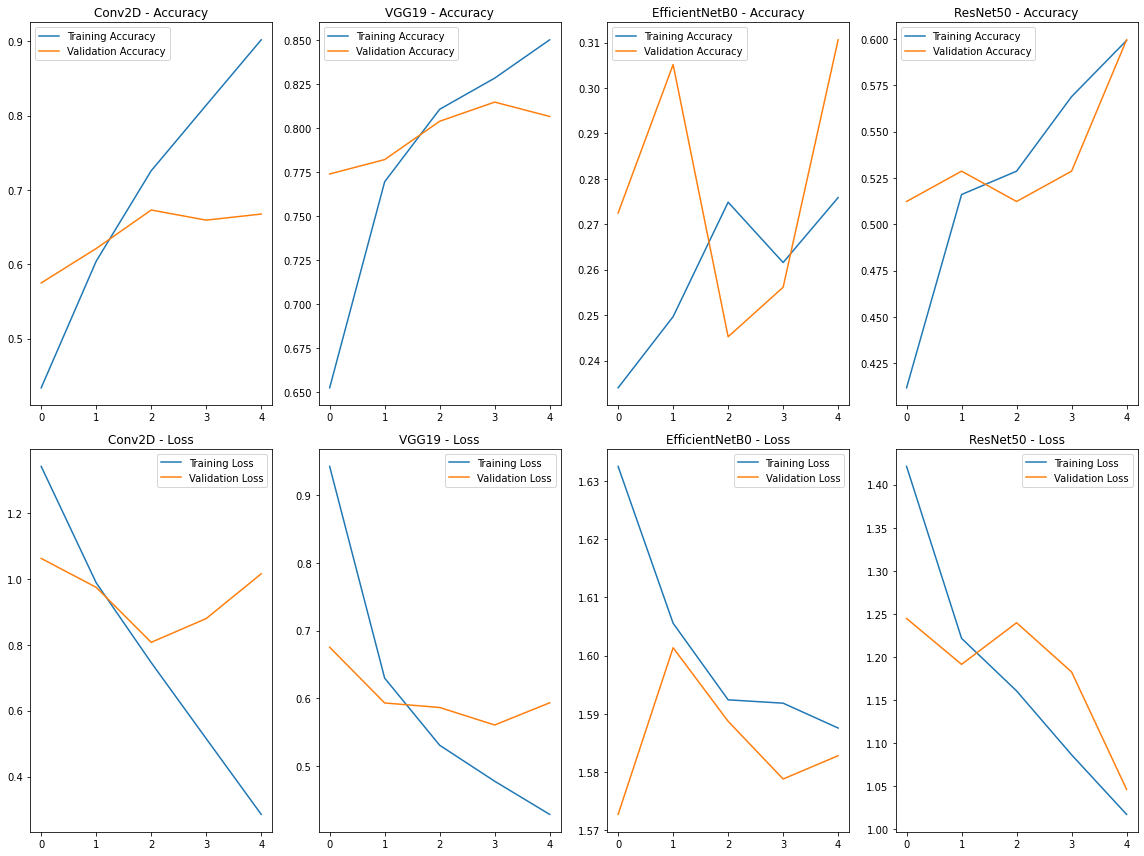


Evaluation:
12/12 [==============================] - 0s 33ms/step - loss: 1.1736 - accuracy: 0.6812
Conv2D Model Accuracy: 0.68
12/12 [==============================] - 1s 84ms/step - loss: 0.5269 - accuracy: 0.8283
VGG19 Model Accuracy: 0.83
12/12 [==============================] - 0s 31ms/step - loss: 1.5914 - accuracy: 0.2916
EfficientNetB0 Model Accuracy: 0.29
12/12 [==============================] - 1s 51ms/step - loss: 1.1020 - accuracy: 0.5722
ResNet50 Model Accuracy: 0.57


In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.applications import VGG19, EfficientNetB0, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리 함수
import tensorflow_datasets as tfds
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # uint8 -> float32 변환
    image = (image / 127.5) - 1  # 픽셀 값을 [-1, 1] 범위로 정규화
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # 이미지 크기 조정
    return image, label

# 데이터셋 전처리
train = raw_train.map(format_example).shuffle(1000).batch(32)
validation = raw_validation.map(format_example).batch(32)
test = raw_test.map(format_example).batch(32)

# 2. Conv2D 기반 모델
conv_model = Sequential([
    Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=5, activation='softmax')  # tf_flowers는 5개 클래스
])
conv_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 3. VGG19 모델
base_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_vgg19.trainable = False  # 사전 학습된 가중치 고정

vgg19_model = Sequential([
    base_vgg19,
    GlobalAveragePooling2D(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')
])
vgg19_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# 4. EfficientNetB0 모델
base_efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_efficientnet.trainable = False  # 사전 학습된 가중치 고정

efficientnet_model = Sequential([
    base_efficientnet,
    GlobalAveragePooling2D(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')
])
efficientnet_model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

# 5. ResNet50 모델
base_resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_resnet50.trainable = False  # 사전 학습된 가중치 고정

resnet50_model = Sequential([
    base_resnet50,
    GlobalAveragePooling2D(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')
])
resnet50_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# 6. 모델 학습 및 history 저장
EPOCHS_CONV = 12
EPOCHS_OTHER = 6
histories = {}

# Conv2D 모델 학습
print("\nTraining Conv2D Model:")
histories['Conv2D'] = conv_model.fit(train, validation_data=validation, epochs=EPOCHS_CONV)

# VGG19 모델 학습
print("\nTraining VGG19 Model:")
histories['VGG19'] = vgg19_model.fit(train, validation_data=validation, epochs=EPOCHS_OTHER)

# EfficientNetB0 모델 학습
print("\nTraining EfficientNetB0 Model:")
histories['EfficientNetB0'] = efficientnet_model.fit(train, validation_data=validation, epochs=EPOCHS_OTHER)

# ResNet50 모델 학습
print("\nTraining ResNet50 Model:")
histories['ResNet50'] = resnet50_model.fit(train, validation_data=validation, epochs=EPOCHS_OTHER)

# 7. 그래프 시각화 함수
def plot_training_history(histories, epochs_range):
    """모델별 Training/Validation Accuracy 및 Loss 시각화"""
    plt.figure(figsize=(16, 12))
    
    for i, (name, history) in enumerate(histories.items()):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        # Accuracy 그래프
        plt.subplot(2, len(histories), i + 1)
        plt.plot(epochs_range[name], acc, label='Training Accuracy')
        plt.plot(epochs_range[name], val_acc, label='Validation Accuracy')
        plt.legend()
        plt.title(f'{name} - Accuracy')
        
        # Loss 그래프
        plt.subplot(2, len(histories), len(histories) + i + 1)
        plt.plot(epochs_range[name], loss, label='Training Loss')
        plt.plot(epochs_range[name], val_loss, label='Validation Loss')
        plt.legend()
        plt.title(f'{name} - Loss')
    
    plt.tight_layout()
    plt.show()

# 8. 그래프 출력
epochs_range = {
    'Conv2D': range(EPOCHS_CONV),
    'VGG19': range(EPOCHS_OTHER),
    'EfficientNetB0': range(EPOCHS_OTHER),
    'ResNet50': range(EPOCHS_OTHER)
}
plot_training_history(histories, epochs_range)

# 9. 평가
print("\nEvaluation:")
print(f"Conv2D Model Accuracy: {conv_model.evaluate(test)[1]:.2f}")
print(f"VGG19 Model Accuracy: {vgg19_model.evaluate(test)[1]:.2f}")
print(f"EfficientNetB0 Model Accuracy: {efficientnet_model.evaluate(test)[1]:.2f}")
print(f"ResNet50 Model Accuracy: {resnet50_model.evaluate(test)[1]:.2f}")